In [1]:
pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import os

In [3]:
# Constants
IMAGE_SIZE_1 = 225
IMAGE_SIZE_2 = 225
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
NUM_CLASSES = 27  # Adjust this based on your dataset
DATASET_PATH = "/content/drive/MyDrive/PharmaScope"

In [4]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE_1, IMAGE_SIZE_2),
    batch_size=BATCH_SIZE
)

Found 3495 files belonging to 27 classes.


In [5]:
# Get class names
class_names = dataset.class_names

In [6]:
# Split dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
# Cache, shuffle, and prefetch the datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [9]:
# Build the model using ResNet50
resnet50 = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS)
)

94765736/94765736 [==============================] - 1s 0us/step


In [10]:
# Freeze the ResNet50 layers
for layer in resnet50.layers:
    layer.trainable = False

model = models.Sequential([
    data_augmentation,
    resnet50,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
# Build the model with the correct input shape
model.build(input_shape=(None, IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS))

In [12]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 225, 225, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                13851     
                                                      

In [13]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
88/88 [==============================] - 357s 2s/step - loss: 1.8902 - accuracy: 0.4547 - val_loss: 1.0107 - val_accuracy: 0.7131
Epoch 2/50
88/88 [==============================] - 6s 74ms/step - loss: 1.0281 - accuracy: 0.6639 - val_loss: 0.7098 - val_accuracy: 0.7699
Epoch 3/50
88/88 [==============================] - 6s 74ms/step - loss: 0.7726 - accuracy: 0.7513 - val_loss: 0.5220 - val_accuracy: 0.8153
Epoch 4/50
88/88 [==============================] - 7s 74ms/step - loss: 0.6319 - accuracy: 0.7979 - val_loss: 0.4509 - val_accuracy: 0.8580
Epoch 5/50
88/88 [==============================] - 6s 74ms/step - loss: 0.5375 - accuracy: 0.8284 - val_loss: 0.3114 - val_accuracy: 0.9233
Epoch 6/50
88/88 [==============================] - 6s 74ms/step - loss: 0.4345 - accuracy: 0.8613 - val_loss: 0.3260 - val_accuracy: 0.8750
Epoch 7/50
88/88 [==============================] - 7s 74ms/step - loss: 0.3841 - accuracy: 0.8793 - val_loss: 0.3791 - val_accuracy: 0.8636
Epoch 8/50
88

In [15]:
# Evaluate the model
scores = model.evaluate(test_ds)
print(f'Test Accuracy: {scores[1]}')

11/11 [==============================] - 158s 56ms/step - loss: 0.0982 - accuracy: 0.9688
Test Accuracy: 0.96875


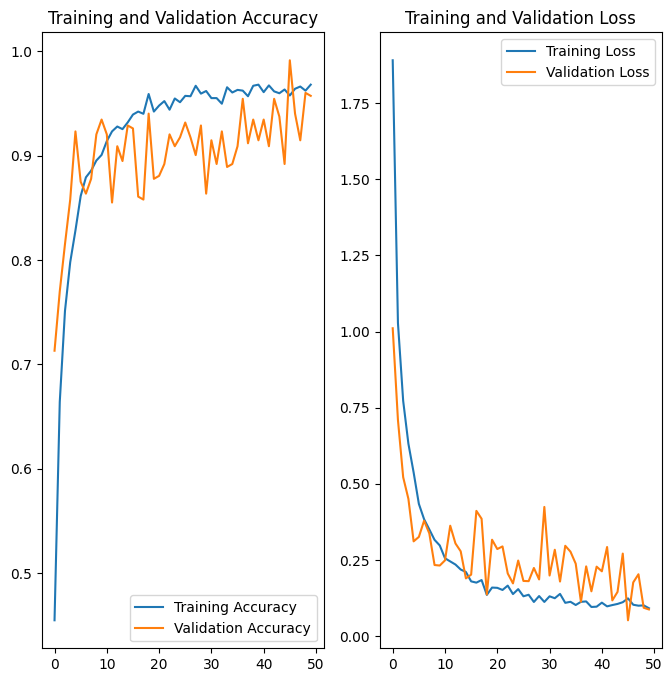

In [16]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# Make predictions
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    preds = model.predict(images_batch)
    y_pred.extend(np.argmax(preds, axis=1))

1/1 [==============================] - 0s 32ms/step


In [18]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[ 9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  1 17  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10

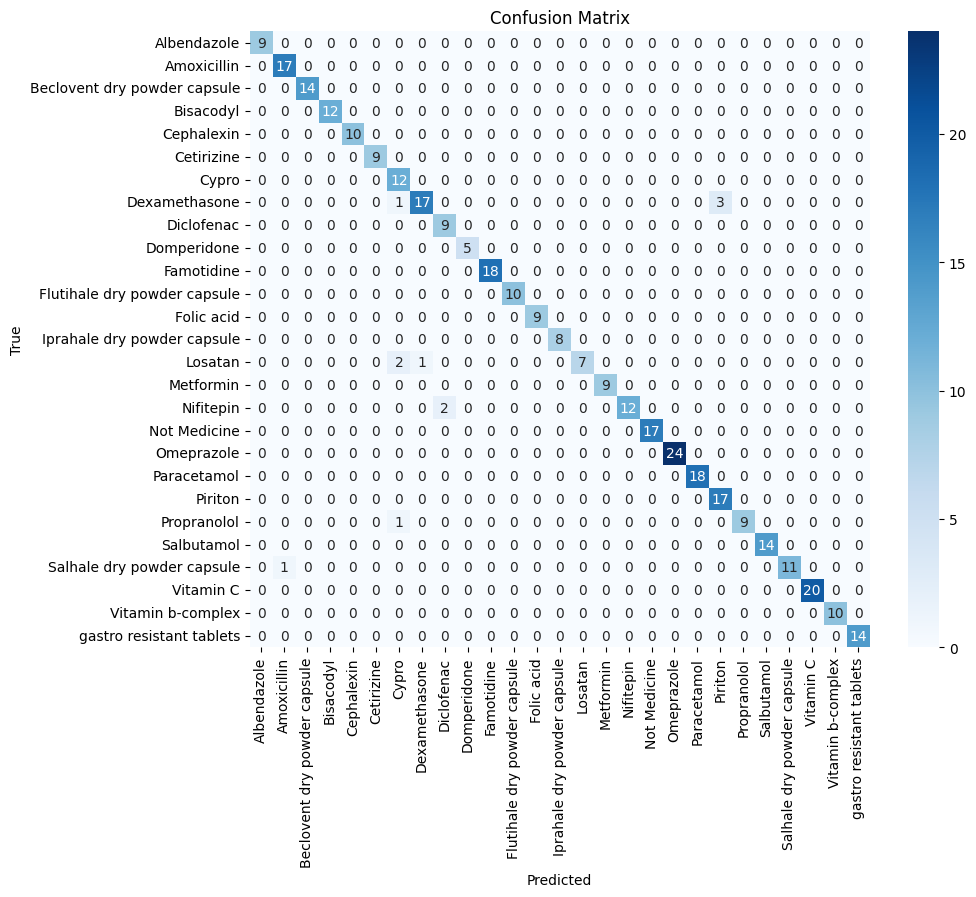

In [19]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Classification report
cr = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report")
print(cr)

Classification Report
                              precision    recall  f1-score   support

                 Albendazole       1.00      1.00      1.00         9
                 Amoxicillin       0.94      1.00      0.97        17
Beclovent dry powder capsule       1.00      1.00      1.00        14
                   Bisacodyl       1.00      1.00      1.00        12
                  Cephalexin       1.00      1.00      1.00        10
                  Cetirizine       1.00      1.00      1.00         9
                       Cypro       0.75      1.00      0.86        12
               Dexamethasone       0.94      0.81      0.87        21
                  Diclofenac       0.82      1.00      0.90         9
                 Domperidone       1.00      1.00      1.00         5
                  Famotidine       1.00      1.00      1.00        18
Flutihale dry powder capsule       1.00      1.00      1.00        10
                  Folic acid       1.00      1.00      1.00        

In [21]:
# Precision, recall, F1 score, and accuracy
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Accuracy: {accuracy}')

Precision: 0.9735867194674012
Recall: 0.96875
F1 Score: 0.968578494460595
Accuracy: 0.96875


In [22]:
model.save(f"/content/drive/MyDrive/CorrectOnes/ResNet50.h5") # Add .keras extension

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
